In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np

warnings.filterwarnings('ignore')

We create a data frame with the time series containing the hourly value of the PM10 concentrations. Then we make a brief statistical analysis and we plot the time series:

In [2]:
PM10=pd.read_csv("PM10_E43.csv",index_col = "DATETIME")
PM10.rename(columns = {'mg/m^3_43':'mg/m^3'}, inplace = True)
PM10

,mg/m^3
DATETIME,
2019-07-01 01:00:00,42.0
2019-07-01 02:00:00,38.0
2019-07-01 03:00:00,34.0
2019-07-01 04:00:00,34.0
2019-07-01 05:00:00,36.0
...,...
2022-06-30 20:00:00,57.0
2022-06-30 21:00:00,39.0
2022-06-30 22:00:00,44.0


In [3]:
PM10.describe()

,mg/m^3
count,24314.000000
mean,26.595583
std,16.898428
min,1.000000
25%,16.000000
50%,24.000000
75%,33.000000
max,543.000000


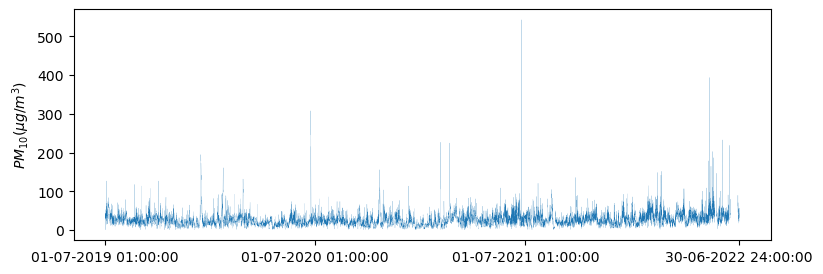

In [28]:
plt.figure(figsize=(9,3))
#sns.set_context("notebook")
#sns.axes_style("whitegrid")
plt.plot(PM10["mg/m^3"],linewidth=.1)
plt.xticks(ticks=[0,8568,17160,25895], labels =["01-07-2019 01:00:00","01-07-2020 01:00:00","01-07-2021 01:00:00","30-06-2022 24:00:00"])
#plt.title('Concentrations of PM10 from 1 Jul 2019 to 1 Jul 2022 by 1h')
#plt.xlabel('Date and time')
plt.ylabel(r'$PM_{10}(\mu g/m^3)$')

plt.savefig("Latex/figures/PM10raw.jpg")
plt.show()

## Missing values imputation

We compute the percentage of missing values and add a new column named _mg/m^3_im_ where we replace them with the mean of the time series.

In [5]:
# % of missing values
1-PM10.count()/len(PM10)

mg/m^3    0.061091
dtype: float64

In [6]:
PM10["mg/m^3_im"] = PM10["mg/m^3"].fillna(PM10["mg/m^3"].mean())
PM10.head()

,mg/m^3,mg/m^3_im
DATETIME,,
2019-07-01 01:00:00,42.0,42.0
2019-07-01 02:00:00,38.0,38.0
2019-07-01 03:00:00,34.0,34.0
2019-07-01 04:00:00,34.0,34.0
2019-07-01 05:00:00,36.0,36.0


# 24h mean analysis

We add a new column _mg/m^3_im_24h_ with the mean of the 24 previous values of the series _mg/m^3_im_24h_:

In [7]:
PM10["mg/m^3_im_24h"] = np.nan

for j in range(23, len(PM10)):

    PM10[ "mg/m^3_im_24h"][j] = PM10["mg/m^3_im"][j-23:j+1].mean()
    
PM10.head(48)

,mg/m^3,mg/m^3_im,mg/m^3_im_24h
DATETIME,,,
2019-07-01 01:00:00,42.0,42.0,NaN
2019-07-01 02:00:00,38.0,38.0,NaN
2019-07-01 03:00:00,34.0,34.0,NaN
2019-07-01 04:00:00,34.0,34.0,NaN
2019-07-01 05:00:00,36.0,36.0,NaN
2019-07-01 06:00:00,34.0,34.0,NaN
2019-07-01 07:00:00,41.0,41.0,NaN
2019-07-01 08:00:00,53.0,53.0,NaN
2019-07-01 09:00:00,5.0,5.0,NaN


We create a new time series _PM10_00_ which contains the mean value of PM10 of every day:

In [8]:
PM10_00=PM10.loc[[x for x in PM10.index if x[-8:]=='00:00:00']]

In [9]:
ind=[]

for j in PM10_00.index:
    ind.append(j[:10])

ind

PM10_00.set_axis(ind, axis='index', inplace=True)


PM10_00= PM10_00["mg/m^3_im_24h"]
PM10_00= PM10_00.to_frame()
PM10_00

,mg/m^3_im_24h
2019-07-02,34.000000
2019-07-03,42.291667
2019-07-04,42.000000
2019-07-05,35.666667
2019-07-06,34.656861
...,...
2022-06-27,26.595583
2022-06-28,26.595583
2022-06-29,36.788906
2022-06-30,41.041667


We plot the 24h mean values and we indicate the AQG level and Interim stages:

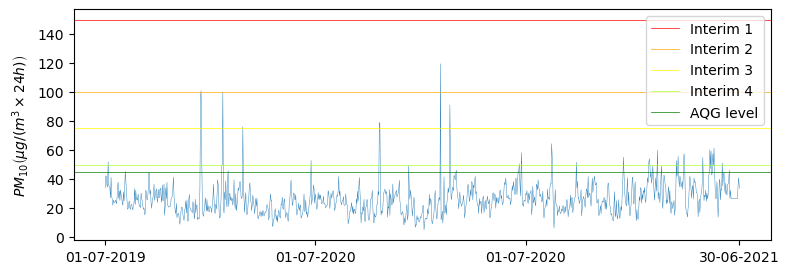

In [26]:
plt.figure(figsize=(9,3))
graph = plt.plot(PM10_00["mg/m^3_im_24h"],linewidth=.3)

plt.axhline(y=150,linewidth=.5 ,color= "red", label = "Interim 1" )
plt.axhline(y=100,linewidth=.5,color ="orange", label = "Interim 2")
plt.axhline(y=75,linewidth=.5, color ="yellow", label = "Interim 3")
plt.axhline(y=50,linewidth=.5,color ="greenyellow", label = "Interim 4")
plt.axhline(y=45,linewidth=.5,color= "green", label = "AQG level")
plt.xticks(ticks=[0, 357, 357+358, 357+358+363], labels =["01-07-2019","01-07-2020","01-07-2020","30-06-2021"])
#plt.title('24h mean of $PM_{10}$ concentrations from 2 Jul 2019 to 1 Jul 2022')
plt.ylabel(r'$PM_{10}\left(\mu g/(m^3\times 24 h)\right)$')

plt.legend(loc = "upper right")
plt.savefig("Latex/figures/PM10_24mean.jpg")
plt.show()

In [11]:
PM10_00["AQG"] = "NA"

for j in range(len(PM10_00)):
    if PM10_00[ "mg/m^3_im_24h"][j]<= 45:
        PM10_00["AQG"][j] = "+"
    elif 45<PM10_00[ "mg/m^3_im_24h"][j]<= 50:
        PM10_00["AQG"][j] = "I1"
    elif 50<PM10_00[ "mg/m^3_im_24h"][j]<= 75:
        PM10_00["AQG"][j] = "I2"
    elif 75<PM10_00[ "mg/m^3_im_24h"][j]<= 100:
        PM10_00["AQG"][j] = "I3"
    elif 100<PM10_00[ "mg/m^3_im_24h"][j]<= 150:
        PM10_00["AQG"][j] = "I4"   
    elif PM10_00[ "mg/m^3_im_24h"][j]> 150:
        PM10_00["AQG"][j] = "-"    
    
PM10_00["AQG"].value_counts()

+     1031
I2      23
I1      17
I3       5
I4       3
Name: AQG, dtype: int64

We quantify which percentage of days have been on every stage divided on three month periods:

In [12]:
h1907_1910 = PM10_00[PM10_00.index<"2019-11"]["AQG"].value_counts()/len(PM10_00[PM10_00.index<"2019-11"]["AQG"])*100
h1911_2002 = PM10_00[("2019-10"< PM10_00.index)&(PM10_00.index<"2020-03")]["AQG"].value_counts()/len(PM10_00[("2019-10"< PM10_00.index)&(PM10_00.index<"2020-03")]["AQG"])*100

h2003_2006 = PM10_00[("2020-02"< PM10_00.index)&(PM10_00.index<"2020-07")]["AQG"].value_counts()/len(PM10_00[("2020-02"< PM10_00.index)&(PM10_00.index<"2020-07")]["AQG"])*100
h2007_2010 = PM10_00[("2020-06"< PM10_00.index)&(PM10_00.index<"2020-11")]["AQG"].value_counts()/len(PM10_00[("2020-06"< PM10_00.index)&(PM10_00.index<"2020-11")]["AQG"])*100
h2011_2102 = PM10_00[("2020-10"< PM10_00.index)&(PM10_00.index<"2021-03")]["AQG"].value_counts()/len(PM10_00[("2020-10"< PM10_00.index)&(PM10_00.index<"2021-03")]["AQG"])*100

h2103_2106 = PM10_00[("2021-02"< PM10_00.index)&(PM10_00.index<"2021-07")]["AQG"].value_counts()/len(PM10_00[("2021-02"< PM10_00.index)&(PM10_00.index<"2021-07")]["AQG"])*100
h2107_2110 = PM10_00[("2021-06"< PM10_00.index)&(PM10_00.index<"2021-11")]["AQG"].value_counts()/len(PM10_00[("2021-06"< PM10_00.index)&(PM10_00.index<"2021-11")]["AQG"])*100
h2111_2202 = PM10_00[("2021-10"< PM10_00.index)&(PM10_00.index<"2022-03")]["AQG"].value_counts()/len(PM10_00[("2021-10"< PM10_00.index)&(PM10_00.index<"2022-03")]["AQG"])*100

h2203_2206 = PM10_00[("2022-02"< PM10_00.index)]["AQG"].value_counts()/len(PM10_00[("2022-02"< PM10_00.index)]["AQG"])*100

In [13]:
data = {'24h1907-1910': h1907_1910,'24h1911-2002': h1911_2002,
        '24h2003-2006': h2003_2006,'24h2007-2010': h2007_2010,'24h2011-2102': h2011_2102,
        '24h2103-2106': h2103_2106,'24h2106-2109': h2107_2110,'24h2111-2202': h2111_2202,
        '24h2203-2206': h2203_2206       
       }
 
# Create DataFrame
per24h = pd.DataFrame(data)
per24h=per24h.fillna(0) 
# Print the output.
per24h

,24h1907-1910,24h1911-2002,24h2003-2006,24h2007-2010,24h2011-2102,24h2103-2106,24h2106-2109,24h2111-2202,24h2203-2206
+,98.290598,95.270270,98.013245,98.000000,95.918367,94.000000,94.771242,95.333333,88.079470
I1,0.854701,1.351351,0.662252,0.000000,1.360544,3.333333,1.960784,2.000000,4.635762
I2,0.854701,1.351351,0.662252,0.666667,0.000000,1.333333,3.267974,2.666667,7.284768
I3,0.000000,0.675676,0.662252,1.333333,2.040816,0.666667,0.000000,0.000000,0.000000
I4,0.000000,1.351351,0.000000,0.000000,0.680272,0.666667,0.000000,0.000000,0.000000


We resume the results in two bar charts the first contains the percentage of days with AQG level and the second contains the percentage of days with Interim levels:

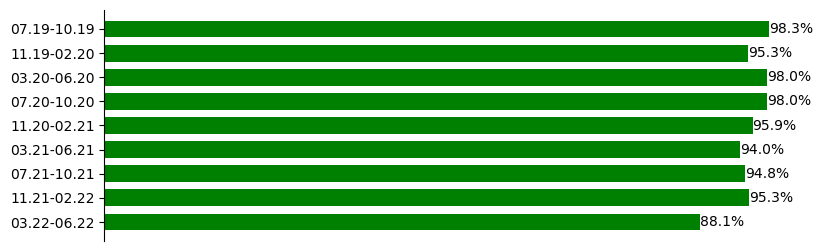

In [24]:
fig, ax = plt.subplots(figsize=(9,3))



x = ["07.19-10.19","11.19-02.20","03.20-06.20","07.20-10.20","11.20-02.21","03.21-06.21","07.21-10.21","11.21-02.22","03.22-06.22",]
p1=ax.barh(x,per24h.values[0],height =.7 ,label='+',color='green')
#p2=ax.barh(x,per24h.values[1],height =.7,left=per24h.values[0],label='I1',color="greenyellow")
#p3=ax.barh(x,per24h.values[2].round(2),height =.7 ,left=per24h.values[0]+per24h.values[1].round(2),label='I2',color="yellow")
#p4=ax.barh(x,per24h.values[3].round(0),height =.7,left=per24h.values[0]+per24h.values[1].round(0)+per24h.values[3].round(0) ,label='I3',color="orange")
#p5=ax.barh(x,per24h.values[4].round(0),height =.7,left=per24h.values[0]+per24h.values[1].round(0)+per24h.values[3].round(0)+per24h.values[3].round(0) ,label='I4',color='orangered')



ax.bar_label(p1,fmt='%.1f%%')
#ax.bar_label(p2,fmt='%.2f%%',label_type='center')
#ax.bar_label(p3,fmt='%1.f%%',label_type='center')
#ax.bar_label(p4,fmt='%1.f%%',label_type='center')
#ax.bar_label(p5,fmt='%1.f%%',label_type='center')
#ax.set_xlabel('Percentage')
#ax.set_ylabel('Time period')
#ax.set_title('Percentage of days on AQG stage')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)


plt.gca().invert_yaxis()
#plt.legend()
plt.xticks([])

plt.savefig("Latex/figures/PM10_per1.jpg")
plt.show()

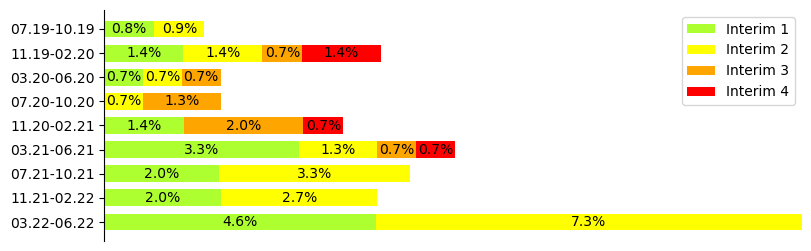

In [25]:
fig, ax = plt.subplots(figsize=(9,3))



x = ["07.19-10.19","11.19-02.20","03.20-06.20","07.20-10.20","11.20-02.21","03.21-06.21","07.21-10.21","11.21-02.22","03.22-06.22",]
#p1=ax.barh(x,per24h.values[0].round(2),height =.7 ,label='+',color='green')
p2=ax.barh(x,per24h.values[1].round(2),height =.7,label='Interim 1',color="greenyellow")
p3=ax.barh(x,per24h.values[2],height =.7 ,label='Interim 2',left=per24h.values[1],color="yellow")
p4=ax.barh(x,per24h.values[3],height =.7 ,label='Interim 3',left=per24h.values[1]+per24h.values[2],color="orange")
p5=ax.barh(x,per24h.values[4],height =.7,label='Interim 4' ,left=per24h.values[1]+per24h.values[2]+per24h.values[3],color="red")

threshold = 0
for c in ax.containers:
    # Filter the labels
    labels = [str(v.round(1))+'%' if v > threshold else "" for v in c.datavalues]    
    ax.bar_label(c,labels=labels, label_type="center")
#ax.bar_label(p1,fmt='%.2f%%',label_type='center')
#ax.bar_label(p2,fmt='%.2f%%',label_type='center')
#ax.bar_label(p3,fmt='%.2f%%',label_type='center')
#ax.bar_label(p4,fmt='%.2f%%',label_type='center')
#ax.bar_label(p5,fmt='%.2f%%',label_type='center')
#ax.set_xlabel('Percentage')
#ax.set_ylabel('Time period')
#ax.set_title('Percentage of days on each Interim stage')

plt.gca().invert_yaxis()
plt.legend()
plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig("Latex/figures/PM10_per2.jpg")
plt.show()

## 24h train forecasting

In [16]:
size = int(len(PM10["mg/m^3_im_24h"])*.8)

train_24, test_24 = PM10["mg/m^3_im_24h"].iloc[:size], PM10["mg/m^3_im_24h"].iloc[size:]

In [17]:
tr_PM10_24_00 = train_24.loc[[x for x in train_24.index if x[-8:]=='00:00:00']]
tr_PM10_24_00[1:].to_csv("tr_PM10_24h_00.csv")

te_PM10_24_00 = test_24.loc[[x for x in test_24.index if x[-8:]=='00:00:00']]
te_PM10_24_00.to_csv("te_PM10_24h_00.csv")

In [18]:
fr_PM10_24_00 =pd.read_csv("fr_PM10_24H_00.csv")
fr_PM10_24_00

,Unnamed: 0,x
0,1,23.241698
1,2,18.162174
2,3,17.785724
3,4,24.052510
4,5,28.547767
...,...,...
211,212,25.985559
212,213,25.985559
213,214,25.985559
214,215,31.402891


In [19]:
te_PM10_24_00=te_PM10_24_00.to_frame()
te_PM10_24_00

,mg/m^3_im_24h
DATETIME,
2021-11-28 00:00:00,11.875000
2021-11-29 00:00:00,11.166667
2021-11-30 00:00:00,22.958333
2021-12-01 00:00:00,31.416667
2021-12-02 00:00:00,14.041667
...,...
2022-06-27 00:00:00,26.595583
2022-06-28 00:00:00,26.595583
2022-06-29 00:00:00,36.788906


In [20]:
test_24=test_24.to_frame()
test_24

,mg/m^3_im_24h
DATETIME,
2021-11-27 05:00:00,13.458333
2021-11-27 06:00:00,13.458333
2021-11-27 07:00:00,13.500000
2021-11-27 08:00:00,13.458333
2021-11-27 09:00:00,13.500000
...,...
2022-06-30 20:00:00,35.208333
2022-06-30 21:00:00,34.458333
2022-06-30 22:00:00,34.416667


In [21]:
te_PM10_24_00["fr_mg/m^3_im_24h"]=''

for j in range(0,216):
    te_PM10_24_00["fr_mg/m^3_im_24h"][j]=fr_PM10_24_00["x"][j]

In [22]:
ind=[]

for j in te_PM10_24_00.index:
    ind.append(j[:10])

ind

te_PM10_24_00.set_axis(ind, axis='index', inplace=True)
te_PM10_24_00

,mg/m^3_im_24h,fr_mg/m^3_im_24h
2021-11-28,11.875000,23.241698
2021-11-29,11.166667,18.162174
2021-11-30,22.958333,17.785724
2021-12-01,31.416667,24.05251
2021-12-02,14.041667,28.547767
...,...,...
2022-06-27,26.595583,25.985559
2022-06-28,26.595583,25.985559
2022-06-29,36.788906,25.985559
2022-06-30,41.041667,31.402891


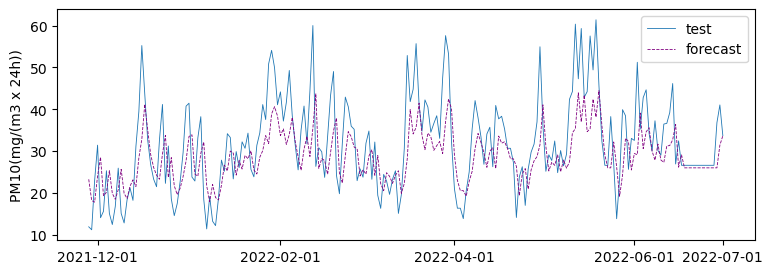

In [23]:
plt.figure(figsize=(9,3))
plt.plot(te_PM10_24_00["mg/m^3_im_24h"],label="test", linewidth=.6)
plt.plot(te_PM10_24_00["fr_mg/m^3_im_24h"],label="forecast",linewidth=.6 ,linestyle='--', color ='purple')


plt.xticks(ticks=[3,65,124,185,215])
plt.ylabel('PM10(mg/(m3 x 24h))')

plt.legend()
plt.savefig("Latex/figures/PM10_for.jpg")

plt.show()